# AI - Computer Assignment #3 #
### Kasra Hajiheidari - 810199400 ###

## Part 1: Implementation using hmmlearn Libraries

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from hmmlearn import hmm
from collections import defaultdict
np.random.seed(400)
import pandas as pd
import seaborn as sn

### Constants ###

In [2]:
BLUES = "./blues/blues."
HIPHOP = "./hiphop/hiphop."
METAL = "./metal/metal."
POP = "./pop/pop."
EXT = ".wav"
COMPONENTS = 4
ITERATIONS = 20
TOTAL_MUSICS = 100
TRAIN_MUSICS = 90
TEST_MUSICS = TOTAL_MUSICS - TRAIN_MUSICS
MAX_FRAMES = 660000
SPLIT_FRAME = 220000

### Utility Functions ###

In [3]:
def addrMake(i: int):
    base = ""
    if(i < 10):
        base = "0000"
    else:
        base = "000"
    base += str(i)
    return base

def getMusic(i, addr: str):
    sig, srange = librosa.load(addr + addrMake(i) + EXT)
    sig = sig[:MAX_FRAMES]
    return sig, srange

### MFCC outputs for each genre ###

In [4]:
def getMFCCFeats(sig, srange):
    # mfc = python_speech_features.mfcc(signal = sig, samplerate=srange, numcep=13, nfft=551)
    mfc = librosa.feature.mfcc(y=sig, n_mfcc=13, sr=srange)
    delta_mfc = librosa.feature.delta(mfc)
    delta_delta_mfc = librosa.feature.delta(mfc, order=2)
    full_mfc_info = np.concatenate((mfc, delta_mfc, delta_delta_mfc))
    return mfc.T, delta_mfc.T, delta_delta_mfc.T, full_mfc_info.T

def loadDisplayMFCC(filename: str, title_name: str):
    sig, srange = getMusic(0, filename)
    mfc, delta_mfc, delta_delta_mfc, full_mfc_info = getMFCCFeats(sig, srange)
    # librosa.display.specshow(mfc, sr=srange)
    # librosa.display.specshow(delta_mfc)
    # librosa.display.specshow(delta_delta_mfc)

    plt.figure(figsize=(25, 10))
    plt.title(title_name)
    librosa.display.specshow(full_mfc_info, x_axis="time", sr=srange)
    plt.colorbar(format="%+2f")

In [5]:
loadDisplayMFCC(HIPHOP, "HipHop")
loadDisplayMFCC(BLUES, "Blues")
loadDisplayMFCC(METAL, "Metal")
loadDisplayMFCC(POP, "Pop")

C:\Users\Mr. Hajiheideri\AppData\Local\Temp\ipykernel_1848\586599039.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  sig, srange = librosa.load(addr + addrMake(i) + EXT)
c:\Users\Mr. Hajiheideri\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: './hiphop/hiphop.00000.wav'

### HMMModel Class

In [ ]:
class HMMModel():
    def __init__(self, components, iter):
        self._components = components
        self._iter = iter
        self._to_be_trained = None
        self.model = None
    
    def addMusicFeat(self, addr):
        feats_list = [
        getMFCCFeats(sig[j*SPLIT_FRAME:(j+1)*SPLIT_FRAME], srange)[3]
        for i in range(TRAIN_MUSICS)
        for j in range(int(MAX_FRAMES/SPLIT_FRAME))
        for sig, srange in [getMusic(i, addr)]
        ]
        self._to_be_trained = np.concatenate(feats_list)
    
    def trainModel(self):
        self.model = hmm.GaussianHMM(n_components=self._components,
                                     n_iter=self._iter
                                     )
        self.model = self.model.fit(self._to_be_trained)
    
    def getLikelihood(self, music):
        return self.model.score(music)

### Training Models ###

In [ ]:
bluesModel = HMMModel(COMPONENTS, ITERATIONS) 
hiphopModel = HMMModel(COMPONENTS, ITERATIONS) 
popModel = HMMModel(COMPONENTS, ITERATIONS) 
metalModel = HMMModel(COMPONENTS, ITERATIONS)

# Append Music Features to the model 
bluesModel.addMusicFeat(BLUES)
hiphopModel.addMusicFeat(HIPHOP)
popModel.addMusicFeat(POP)
metalModel.addMusicFeat(METAL)

# Train Models based on the given features
bluesModel.trainModel()
hiphopModel.trainModel()
popModel.trainModel()
metalModel.trainModel()

### Testing Accuracy of each Model 

In [ ]:
def determineCategory(bluesModel, hiphopModel, popModel, metalModel, sig, srange):
    sig = sig[:MAX_FRAMES]
    blues_likely = 0
    hiphop_likely = 0
    pop_likely = 0
    metal_likely = 0
    for i in range(int(MAX_FRAMES/SPLIT_FRAME)):
        _, _, _, feats = getMFCCFeats(sig[i*SPLIT_FRAME:(i+1)*SPLIT_FRAME], srange)
        if not (type(bluesModel) is HMMModel):
            feats = feats.T
        blues_likely += bluesModel.getLikelihood(feats)
        hiphop_likely += hiphopModel.getLikelihood(feats)
        pop_likely += popModel.getLikelihood(feats)
        metal_likely += metalModel.getLikelihood(feats)
    
    max_likely = metal_likely
    cat = "metal"
    if(max_likely < hiphop_likely):
        max_likely = hiphop_likely
        cat = "hiphop"
    if(max_likely < pop_likely):
        max_likely = pop_likely
        cat = "pop"
    if(max_likely < blues_likely):
        max_likely = blues_likely
        cat = "blues"

    return cat

def confusionTestAcc(bluesModel, hiphopModel, popModel, metalModel):
    cat_list_addr = [POP, BLUES, HIPHOP, METAL]
    cat_list = [c.split("/")[1] for c in cat_list_addr]
    inacc = [0 for x in range(len(cat_list))]
    conf_mat = defaultdict(int)
    for ci in range(len(cat_list)):
        for i in range(TRAIN_MUSICS, TRAIN_MUSICS+TEST_MUSICS):
            sig, srange = getMusic(i, cat_list_addr[ci])
            d_cat = determineCategory(bluesModel, hiphopModel, popModel, metalModel, sig, srange)
            if(cat_list[ci] != d_cat):
                inacc[ci] += 1
            conf_mat[(cat_list[ci], d_cat)] +=1
            print("given music was" + cat_list_addr[ci] + addrMake(i) + EXT + " detected music was: " + d_cat)
        print("~~~~~~~~~~~~")

    for ci in range(len(cat_list)):
        print("accuracy for " + cat_list[ci] + ": ", (1-(inacc[ci]/TEST_MUSICS))*100)
    return conf_mat

lib_conf_mat = confusionTestAcc(bluesModel, hiphopModel, popModel, metalModel)

given music was./pop/pop.00090.wav detected music was: pop
given music was./pop/pop.00091.wav detected music was: pop
given music was./pop/pop.00092.wav detected music was: pop
given music was./pop/pop.00093.wav detected music was: pop
given music was./pop/pop.00094.wav detected music was: pop
given music was./pop/pop.00095.wav detected music was: pop
given music was./pop/pop.00096.wav detected music was: pop
given music was./pop/pop.00097.wav detected music was: pop
given music was./pop/pop.00098.wav detected music was: pop
given music was./pop/pop.00099.wav detected music was: pop
~~~~~~~~~~~~
given music was./blues/blues.00090.wav detected music was: blues
given music was./blues/blues.00091.wav detected music was: blues
given music was./blues/blues.00092.wav detected music was: blues
given music was./blues/blues.00093.wav detected music was: blues
given music was./blues/blues.00094.wav detected music was: blues
given music was./blues/blues.00095.wav detected music was: blues
given m

## Part 2: Implementation from Scratch ##

### HMM Class ###

In [ ]:
class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(self.num_hidden_states, 1))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None

    def _forward(self, observation_matrix: np.ndarray):
        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)

        for t in range(T):
            if t == 0:
                for states in range(observation_matrix.shape[0]):
                    alpha[states][t] = self.initial_prob[states] * observation_matrix[states][t]
                ## TODO: Forward algorithm for the first time step
            else:
                for j in range(observation_matrix.shape[0]):
                    alpha[j][t] = 0
                    for i in range(observation_matrix.shape[0]):
                        alpha[j][t] +=\
                            alpha[i][t-1] *\
                                self.transition_matrix[i][j] * observation_matrix[j][t]
                ## TODO: Forward algorithm for the next time steps

            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += alpha_sum

        return log_likelihood, alpha

    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)

        beta[:, -1] = np.ones(observation_matrix.shape[0])

        for t in range(T - 1)[::-1]:
            # beta[:, t] = ## TODO: Backward algorithm for the time steps of the HMM
            for i in range(observation_matrix.shape[0]):
                beta[i][t] = 0
                for j in range(observation_matrix.shape[0]):
                    beta[i][t] +=\
                        self.transition_matrix[i][j] *\
                            observation_matrix[j][t+1] * beta[j][t+1]
            beta[:, t] /= np.sum(beta[:, t])

        return beta

    def _state_likelihood(self, obs: np.ndarray):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))

        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            temp = np.random.multivariate_normal(self.mean[:, s],
                                                    np.cov(self.covariances[:,:,s]),
                                                    int(int(obs.shape[1])//int(obs.shape[0])+1)).flatten()
            ## TODO: Compute the likelihood of observations with multivariate normal pdf
            B[s, :] = np.array(temp)[:int(obs.shape[1])]

        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))

        for s in range(self.num_hidden_states):
            # TODO: Compute the likelihood of observations with multivariate normal pdf
            mean_reshape = self.mean[:, s].reshape((self.num_dimensions, 1))
            obsmean_transpose = np.array(obs - mean_reshape).T
            B[s, :] =  -0.5 * (np.sum(np.dot(obsmean_transpose, np.linalg.inv(self.covariances[:, :, s])) * obsmean_transpose, axis=1) +\
                (self.num_dimensions * np.log(2 * np.pi) + np.log(np.linalg.det(self.covariances[:, :, s]))))
            # multivariate_normal(self.mean[:, s].reshape((self.num_dimensions), 1),
            #                               self.covariances[:, :, s]).pdf(obs)   

        return B

    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]

        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]

        B = self._state_likelihood(obs) ## TODO

        log_likelihood, alpha = self._forward(B) ## TODO
        beta = self._backward(B) ## TODO

        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))

        for t in range(T - 1):
            partial_sum = np.zeros(xi_sum.shape) ## TODO
            for i in range(self.num_hidden_states):
                for j in range(self.num_hidden_states):
                    partial_sum[i][j] += alpha[i][t] * self.transition_matrix[i][j] *\
                        B[j][t+1] * beta[j][t+1]
            xi_sum += self._normalize(partial_sum)
            partial_g = np.zeros(self.num_hidden_states) ## TODO
            for i in range(self.num_hidden_states):
                for j in range(self.num_hidden_states):
                    partial_g[i] += partial_sum[i][j]
            gamma[:, t] = self._normalize(partial_g)
        partial_g = alpha[:, T-1] ## TODO
        gamma[:, -1] = self._normalize(partial_g)

        expected_prior = gamma[:, 0] ## TODO
        expected_transition = np.zeros((self.num_hidden_states, self.num_hidden_states))
        for i in range(self.num_hidden_states):
            for j in range(self.num_hidden_states):
                expected_transition[i][j] += xi_sum[i][j]
        expected_transition = self._stochasticize(expected_transition)

        expected_covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None] 

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.covariances = expected_covariances
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=4):
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood
    
    def getLikelihood(self, obs):
        return self.score(obs)

### Train Models ###

In [ ]:
def trainHMM(hmmmodel: HMM, addr: str):
    for i in range(TRAIN_MUSICS):
        sig, srange = getMusic(i, addr)
        for j in range(int(MAX_FRAMES/SPLIT_FRAME)):
            _, _, _, feats = getMFCCFeats(sig[j*SPLIT_FRAME:(j+1)*SPLIT_FRAME], srange)
            hmmmodel.train(feats.T)


bluesHMM = HMM(COMPONENTS)
popHMM = HMM(COMPONENTS)
metalHMM = HMM(COMPONENTS)
hiphopHMM = HMM(COMPONENTS)

trainHMM(bluesHMM, BLUES)
trainHMM(popHMM, POP)
trainHMM(metalHMM, METAL)
trainHMM(hiphopHMM, HIPHOP)

C:\Users\Mr. Hajiheideri\AppData\Local\Temp\ipykernel_17088\3677813450.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha[states][t] = self.initial_prob[states] * observation_matrix[states][t]


### Testing Accuracy of each Model ###

In [ ]:
my_hmm_conf_mat = confusionTestAcc(bluesHMM, hiphopHMM, popHMM, metalHMM)

given music was./pop/pop.00090.wav detected music was: pop
given music was./pop/pop.00091.wav detected music was: pop
given music was./pop/pop.00092.wav detected music was: pop
given music was./pop/pop.00093.wav detected music was: pop
given music was./pop/pop.00094.wav detected music was: pop
given music was./pop/pop.00095.wav detected music was: pop
given music was./pop/pop.00096.wav detected music was: pop
given music was./pop/pop.00097.wav detected music was: pop
given music was./pop/pop.00098.wav detected music was: pop
given music was./pop/pop.00099.wav detected music was: pop
~~~~~~~~~~~~
given music was./blues/blues.00090.wav detected music was: hiphop
given music was./blues/blues.00091.wav detected music was: blues
given music was./blues/blues.00092.wav detected music was: blues
given music was./blues/blues.00093.wav detected music was: blues
given music was./blues/blues.00094.wav detected music was: pop
given music was./blues/blues.00095.wav detected music was: metal
given mu

## Answering Questions ##

1) States: A _state_ is somewhere that a model can transition into, a set of parameters also could be an indicator of a state, which changing them through an action may lead into another state which has different statistics.<br><br>
Observations: An _observation_ is what can be acheived through the environment which will act as an evidence sometimes to indicate which state the model is in.<br><br>
In this project, the states are phases that the music can get into. Although It might not have much meaning. We determine the states using a constant called `COMPONENTS`.<br><br>
Observations are obtained using what we get which is the _30-second_ musics. Then we perform MFCC to break the music into features to be able to categorize the musics better.<br><br>
2) There are typically two major categories for HMM Models:
- DHMM (Discrete Hidden Markov Models)
- CHMM (Continuous Hidden Markov Models)<br><br>
First-Order HMM: It is a HMM in which the probability of an observation is only dependent on the previous observation. This HMM falls into the first category (DHMM).<br>
Other DHMMs include HDP-HMM (Hierarchical Dirichlet Process HMM) which is a Bayesian non-parametric alternative for HMMs, MEHMM (Maximum Entropy HMM) directly models the conditional distribution of hidden states using logistic regression.<br><br>
3) HMM applications include:
- Automatic Speech Recognition
- Handwriting Recognition
- Gesture Recognition
- Musical Score
- Bioinformatics<br><br>
Thats because, HMMs can be used for the following problems:
- Likelihood Problem
- Decoding Problem
- Learning Problem<br><br>
4) Advantages and Disadvantages of the HMMs<br><br>
Advantages:
- Flexibility: They can be tailored to different levels of granularity, such as phonemes, words, or phrases.
- Robustness: They can handle noise and distortion.
- Efficiency: Since they are well studied over the years many good algorithms like Expectation-Maximization or others can be applied to them and to work alongside other models, acheiving high accuracy at a high speed.<br><br>
Disadvantages:
- Due to their Markovian nature, they don't take the sequence of states leading into any given state into account
- The time in a given state can not be explicitly/directly captured.
- They take strong assumptions and therefore may not consider dependencies between appliances cannot be represented and other factors.
5) Continuous-Time HMMs
In a CT-HMM time passes by between each observation, which a key contrast between this model and others. Hence we also want to know possibilities the parameter of time opens up to us and be able to predict states between these observation times.

## Analysis and Results ##
As stated in the links lets assume:
- TN: True Negative
- TP: True Positive
- FN: False Negative 
- FP: False Positive <br>
$$Precision = \frac{TP}{TP+FP}\\$$
$$Accuracy = \frac{TN + TP}{TN+FP+TP+FN}$$
$$Recall = \frac{TP}{TP+FN}$$
$$F1\ Score = 2*\frac{Precision * Recall}{Precision + Recall}$$
<br><br>

1) 
- Precision: Precision represents the number of true positive predictions dnominated by all positive predictions
- Accuracy: Accuracy represents the number of correctly classified data instances over the total number of data instances.
- Recall: Recall represents the number of true positive predictions denominated by sum of true positives and false negative predictions
- F1 Score: This method takes both Precision and Recall into account<br><br>

2) 
Precision only regards positves that it didn't predict correctly, while on the other hand Recall does the same thing with negatives that it didn't predict correctly, therefore we need a combination of both of them to be able to evaluate our model correctly.<br><br>
_Example_:<br>
For precision let's say the model had 1 true positives and 100 false negatives the precision would still be 1 (highest value), which means our model did a pretty good job which is not the case.<br>
For recall we could do the same thing with false positives, again, the result would be the same and we are not evaluating our model correctly, when we are only regarding recall as the evaluation of our model.<br><br>

3) 
F1-score uses a harmonic mean,The harmonic mean is calculated by dividing the number of observations, or entries in the series, by the reciprocal of each number in the series. In contrast, the arithmetic mean is simply the sum of a series of numbers divided by the count of numbers in that series.<br><br>


4) 
- Macro: computed by taking an unweighted mean of all the per-class scores
- Micro: In contrast to macro, micro average computes a global average by counting the sums of true positive (TP), false negative (FN) and false positive (FP).
- Weighted: computes the mean of all per-class scores while considering each class’s support. In this case, support is the number of actual instances of the class in the dataset.<br><br>

5) 


hmmlearn Confusion Matrix:


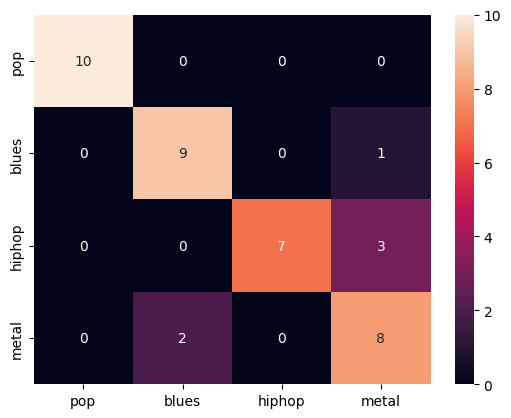

hmm implementation Confusion Matrix:


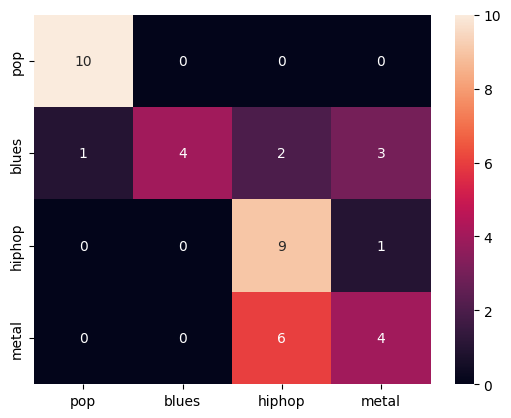

In [ ]:
def drawConfusionMatrix(cat_list, conf_mat):
    mat = []
    for i in range(len(cat_list)):
        mat.append([conf_mat[(cat_list[i], cat_list[j])] for j in range(len(cat_list))])

    cat_map = pd.DataFrame(mat, index=[cat for cat in cat_list],
                           columns=[cat for cat in cat_list])
    sn.heatmap(cat_map, annot=True)
    plt.show()
cat_list_addr = [POP, BLUES, HIPHOP, METAL]
cat_list = [c.split("/")[1] for c in cat_list_addr]
print("hmmlearn Confusion Matrix:")
drawConfusionMatrix(cat_list, lib_conf_mat)
print("hmm implementation Confusion Matrix:")
drawConfusionMatrix(cat_list, my_hmm_conf_mat)

In [ ]:
def TP(base, target, conf_mat):
    if(base != target):
        return 0
    return conf_mat[(target, target)]
def TN(base, target, conf_mat, cat_list):
    if(base == target):
        return 0
    else:
        row_tn = 0
        for c in cat_list:
            if(c == base):
                continue
            else:
                row_tn += conf_mat[(target, c)]
        return row_tn
def FP(base, target, conf_mat):
    if(base == target):
        return 0
    else:
        return conf_mat[(target, base)]
def FN(base, target, conf_mat, cat_list):
    if(base != target):
        return 0
    else:
        row_fn = 0
        for c in cat_list:
            if(c == base):
                continue
            else:
                row_fn += conf_mat[(target, c)]
        return row_fn
def d(x):
    if(x==0):
        return 1
    else:
        return x
    
def modelAnalyzer(cat_list, conf_mat):
    print("Macro")
    cls_pr_sm = 0
    cls_ac_sm = 0
    cls_rec_sm = 0
    cls_f1_sm = 0
    for cls in cat_list:
        cls_pr = 0
        cls_ac = 0
        cls_rec = 0
        cls_f1 = 0
        for base in cat_list:
            argp = (base, cls, conf_mat)
            argn = (base, cls, conf_mat, cat_list)
            cls_pr += TP(*argp) / d(TP(*argp) + FP(*argp))
            cls_ac += (TN(*argn) + TP(*argp)) / d(TN(*argn) + TP(*argp) + FP(*argp) + FN(*argn))
            cls_rec += TP(*argp) / d(TP(*argp) + FN(*argn))
            cls_f1 += 2 * (cls_pr * cls_rec) / d(cls_pr + cls_rec)
        
        print("-- " + cls)
        print("Precision: ", cls_pr/len(cat_list))
        print("Accuracy:  ", cls_ac/len(cat_list))
        print("Recall:    ", cls_rec/len(cat_list))
        print("F1 Score:  ", cls_f1/len(cat_list))
        print("")
    
    print("~~~\n")
    print("Micro")
    glob_tp = 0
    glob_tn = 0
    glob_fp = 0
    glob_fn = 0
    for cls in cat_list:
        for base in cat_list:
            glob_tp += TP(base, cls, conf_mat)
            glob_tn += TN(base, cls, conf_mat, cat_list)
            glob_fp += FP(base, cls, conf_mat)
            glob_fn += FN(base, cls, conf_mat, cat_list)
    
    glob_pr = glob_tp / d(glob_tp + glob_fp)
    glob_acc = (glob_tp + glob_tn) / d(glob_tp + glob_tn + glob_fp + glob_fn)
    glob_rec = glob_tp / d(glob_tp + glob_fn)
    glob_f1 = 2 * (glob_pr * glob_rec) / d(glob_pr + glob_rec)
    print("Precision: ", glob_pr)
    print("Accuracy:  ", glob_acc)
    print("Recall:    ", glob_tp / d(glob_tp + glob_fn))
    print("F1 Score:  ", glob_f1)
    print("")
    print("~~~\n")
    print("Weighted is like Macro since instances are the same")


print("++ hmmlearn evaluation:\n")
modelAnalyzer(cat_list, lib_conf_mat)
print("\n++++++++++++++++++++\n")
print("++ hmm implementation evaluation:\n")
modelAnalyzer(cat_list, my_hmm_conf_mat)

++ hmmlearn evaluation:

Macro
-- pop
Precision:  0.25
Accuracy:   1.0
Recall:     0.25
F1 Score:   1.0

-- blues
Precision:  0.25
Accuracy:   0.95
Recall:     0.225
F1 Score:   0.7105263157894737

-- hiphop
Precision:  0.25
Accuracy:   0.8500000000000001
Recall:     0.175
F1 Score:   0.4117647058823529

-- metal
Precision:  0.25
Accuracy:   0.8999999999999999
Recall:     0.2
F1 Score:   0.22222222222222224

~~~

Micro
Precision:  0.85
Accuracy:   0.925
Recall:     0.85
F1 Score:   0.85

~~~

Weighted is like Macro since instances are the same

++++++++++++++++++++

++ hmm implementation evaluation:

Macro
-- pop
Precision:  0.25
Accuracy:   1.0
Recall:     0.25
F1 Score:   1.0

-- blues
Precision:  0.25
Accuracy:   0.7
Recall:     0.1
F1 Score:   0.4285714285714286

-- hiphop
Precision:  0.25
Accuracy:   0.95
Recall:     0.225
F1 Score:   0.4736842105263158

-- metal
Precision:  0.25
Accuracy:   0.7
Recall:     0.1
F1 Score:   0.14285714285714288

~~~

Micro
Precision:  0.675
Accuracy

6) 
As expected the hmmlearn library performed better. All of the evaluations are higher than the one with the implementation

7) 
In our model we are using a multivariate normal distribution each time for the B matrix (emission probabilities), while in the hmmlearn model we have the freedom to give all of the data and for it to learn them all together.<br>
Another thing is how we are distributing probabilities and how hmmlearn distributes them, for instance we are using a diagonal one (`np.diag`).<br>
`hmmlearn` being efficient, gave us the freedom to train the model at higher iterations while our implementation's time would skyrocket after 4 iterations.